# Fully Bayesian GPs
In this notebook, we’ll demonstrate how to integrate DMGP and MCMC to sample GP parameters and perform GP inference in a fully Bayesian way.

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from dmgp.models import DMGP
from dmgp.layers.linear import LinearFlipout

In [2]:
# Training data is 1000 points randomly selected by Normal distribution
inputs = np.random.random((1000, 2))
outputs = 1 / (1 + np.exp(np.sum(inputs, axis=-1)))
inputs = inputs.astype(np.float32)
outputs = np.squeeze(outputs).astype(np.float32)

class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = RegressionDataset(inputs, outputs)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
from dmgp.utils.sparse_design.design_class import HyperbolicCrossDesign
from dmgp.kernels.laplace_kernel import LaplaceProductKernel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

# Define the model using DMGP
model = DMGP(input_dim=2,
             output_dim=1,
             num_layers=2,
             hidden_dim=8,
             num_inducing=3,
             input_lb=-2,
             input_ub=2,
             kernel=LaplaceProductKernel(1.),
             design_class=HyperbolicCrossDesign,
             layer_type=LinearFlipout,
             option='additive').to(device)

Using:  cpu


## Training the model
In the next cell, we handle using variational inference (VI) to train the parameters of the DMGP. During each step, we use MCMC to sample the log-likelihood for ELBO loss.

In [4]:
def train(model, optimizer, train_loader, num_mc=5):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()
        output_ = []
        kl_ = []
        for mc_run in range(num_mc):  # Run MCMC to sample log-likelihood
            output, kl = model(data)
            output_.append(output)
            kl_.append(kl)
        output = torch.mean(torch.stack(output_), dim=0)
        kl = torch.mean(torch.stack(kl_), dim=0)
        nll_loss = F.mse_loss(output, target)
        # ELBO loss
        loss = nll_loss + (kl / 64)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

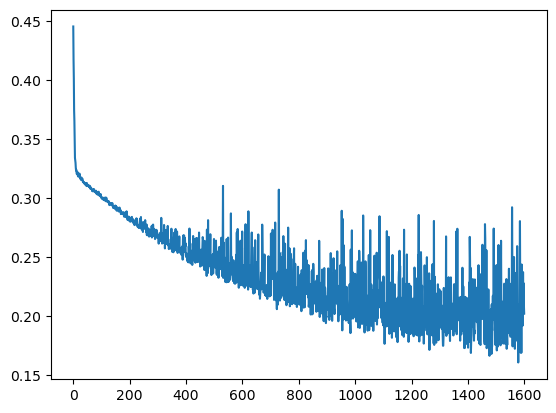

In [5]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.999)

losses = []
for epoch in range(100):
    loss = train(model, optimizer, train_loader, num_mc=5)
    scheduler.step()
    losses += loss
        
plt.plot(losses)

## Running Sampling
In the next cell, we evaluate the model by loading the samples generated by MCMC. This converts `model` from a single DGP to a batch of `num_monte_carlo` DGPs, in this case 20.

In [6]:
def evaluate(model, test_loader, num_monte_carlo=20):
    test_loss = []
    with torch.no_grad():
        for data, target in test_loader:
            target = target.to(device)
            data = data.to(device)

            predicts = []
            for mc_run in range(num_monte_carlo):
                model.eval()
                output, _ = model(data)
                loss = F.mse_loss(output, target).cpu().data.numpy()
                test_loss.append(loss)
                predicts.append(output.cpu().data.numpy())

            pred_mean = np.mean(predicts, axis=0)
            pred_var = np.var(predicts, axis=0)

            # print('prediction mean: ', pred_mean, 'prediction var: ', pred_var)

        print('test loss: ', np.mean(test_loss))

In [7]:
evaluate(model, test_loader)

test loss:  0.30059555
